In [266]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from fancyimpute import IterativeImputer
import warnings
warnings.filterwarnings('ignore')

In [267]:
# Load the data
data = pd.read_csv('payment-practicesold.csv')

In [268]:
# Drop columns that are not useful for the model
columns_to_drop = ['Report Id','Start date', 'End date', 'Filing date', 'Company', 'Company number','URL']
data = data.drop(columns=columns_to_drop)

In [269]:
# assigning types of features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object','bool']).columns
missing_data_cols = [i for i in categorical_features if data[i].isnull().sum() > 0]
non_missing_cat = [i for i in categorical_features if i not in missing_data_cols]

In [270]:
# Missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,10381,42.852425
Average time to pay,2448,10.105263
% Invoices paid within 30 days,2448,10.105263
% Invoices paid between 31 and 60 days,2448,10.105263
% Invoices paid later than 60 days,2448,10.105263
% Invoices not paid within agreed terms,2405,9.927761
Shortest (or only) standard payment period,2405,9.927761
Longest standard payment period,9919,40.945304
Maximum contractual payment period,2405,9.927761
Payment terms have changed,2405,9.927761


In [271]:
data = data.dropna(subset=['E-Invoicing offered'])

In [272]:
data['Payments made in the reporting period'].fillna(0, inplace=True)
data['Suppliers notified of changes'].fillna(1, inplace=True)

In [273]:
for col in numerical_features:
    data[col] = data[col].fillna(data[col].mean())

In [274]:
mice_imputer = IterativeImputer()
data_imputed = mice_imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=data.columns)
data = data_imputed

In [275]:
#missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,0,0.0
Average time to pay,0,0.0
% Invoices paid within 30 days,0,0.0
% Invoices paid between 31 and 60 days,0,0.0
% Invoices paid later than 60 days,0,0.0
% Invoices not paid within agreed terms,0,0.0
Shortest (or only) standard payment period,0,0.0
Longest standard payment period,0,0.0
Maximum contractual payment period,0,0.0
Payment terms have changed,0,0.0


80th Quantile =  51.0


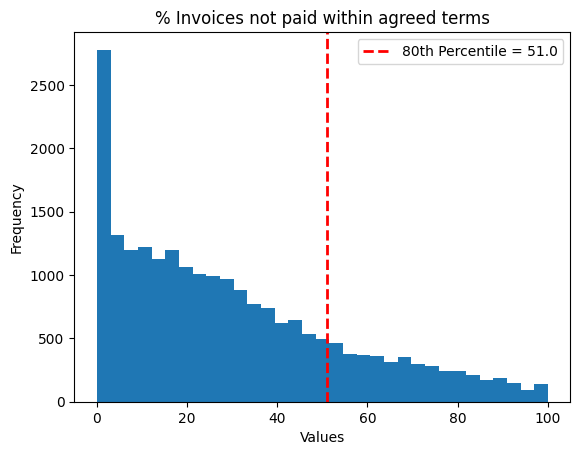

In [276]:
# Bar plot for '% Invoices not paid within agreed terms' and 80th percentile
percentile_80 = np.percentile(data['% Invoices not paid within agreed terms'].dropna(), 80)
print('80th Quantile = ',percentile_80)

plt.hist(data['% Invoices not paid within agreed terms'],bins=33)
plt.axvline(x=percentile_80, color='red', linestyle='dashed', linewidth=2, label='80th Percentile = '+str(percentile_80))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('% Invoices not paid within agreed terms')

# Show the plot
plt.legend()
plt.show()

In [277]:
# Creating target column 'flag' based on the 80th percentile
data['flag'] = 0
data.loc[data['% Invoices not paid within agreed terms'] > percentile_80, 'flag'] = 1
data.drop(columns=['% Invoices not paid within agreed terms'],inplace=True)

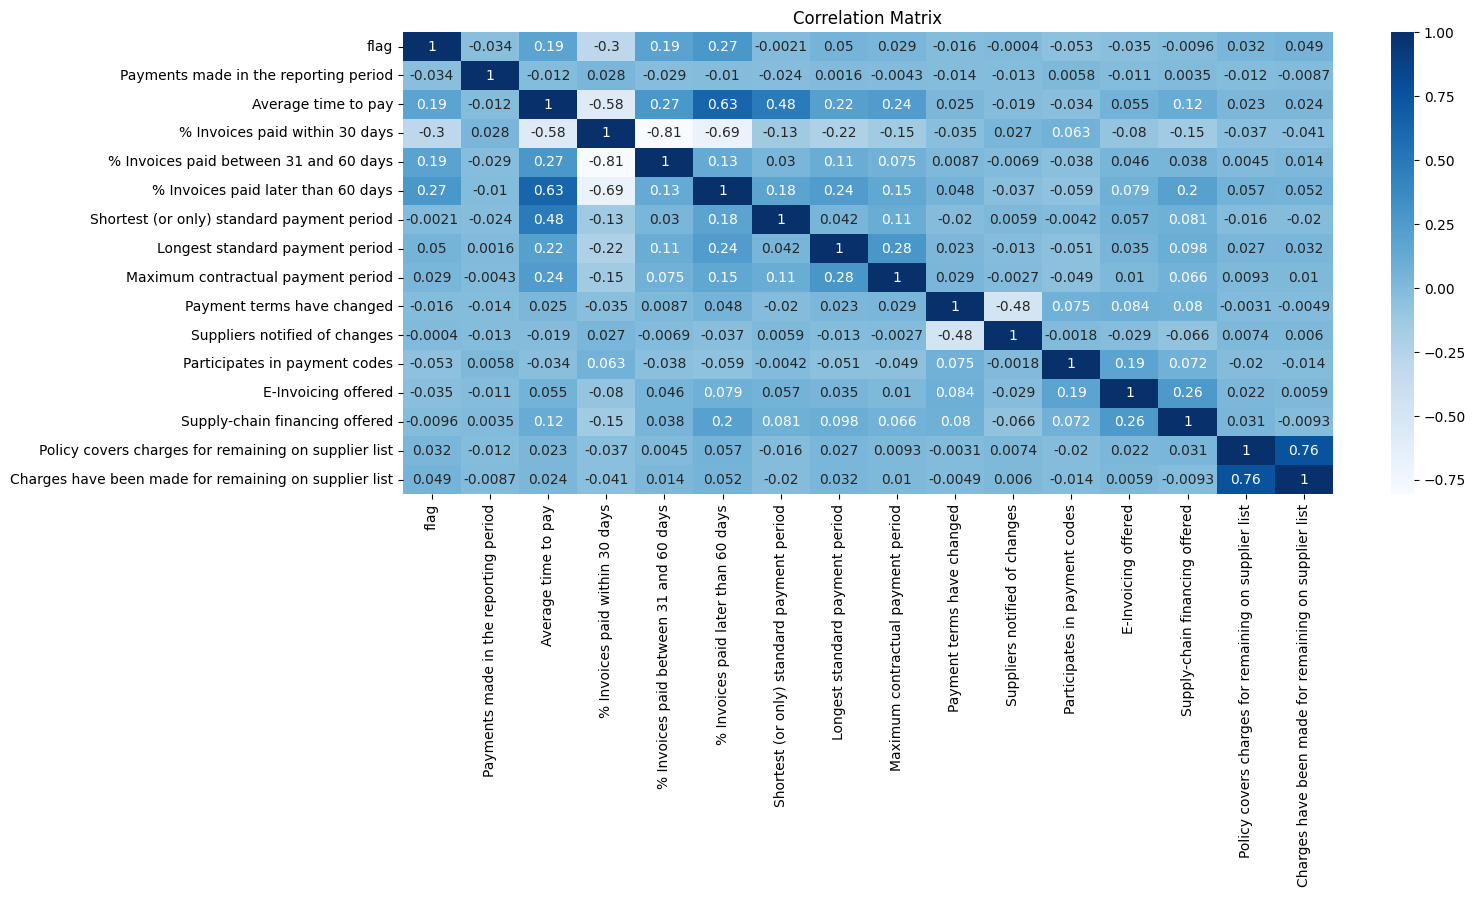

In [278]:
# Correlation Analysis
new_order=[     'flag',
                'Payments made in the reporting period', 'Average time to pay',
                '% Invoices paid within 30 days',
                '% Invoices paid between 31 and 60 days',
                '% Invoices paid later than 60 days',
                'Shortest (or only) standard payment period',
                'Longest standard payment period', 'Maximum contractual payment period',
                'Payment terms have changed', 'Suppliers notified of changes',
                'Participates in payment codes', 'E-Invoicing offered',
                'Supply-chain financing offered',
                'Policy covers charges for remaining on supplier list',
                'Charges have been made for remaining on supplier list']
# Visualize the relationship between numerical columns using a correlation matrix
correlation_matrix = data.reindex(columns=new_order).corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix,annot=True,cmap='Blues')
plt.title('Correlation Matrix')
plt.show()



In [279]:
correlation_threshold = 0.7
for feature, feature_values in correlation_matrix.items():
  for other_feature, correlation in feature_values.items():
    if feature != other_feature and abs(correlation) >= correlation_threshold:
      print(f"{feature} is highly correlated with {other_feature} (correlation: {correlation:.2f})")


% Invoices paid within 30 days is highly correlated with % Invoices paid between 31 and 60 days (correlation: -0.81)
% Invoices paid between 31 and 60 days is highly correlated with % Invoices paid within 30 days (correlation: -0.81)
Policy covers charges for remaining on supplier list is highly correlated with Charges have been made for remaining on supplier list (correlation: 0.76)
Charges have been made for remaining on supplier list is highly correlated with Policy covers charges for remaining on supplier list (correlation: 0.76)


In [280]:
# Dropping the Highly correlated Features
data1 = data.drop(columns=[ '% Invoices paid within 30 days', 
                            '% Invoices paid later than 60 days',
                            'Suppliers notified of changes',
                            'Policy covers charges for remaining on supplier list',])

In [281]:
X = data.drop(columns=['flag'])
y = data['flag']

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

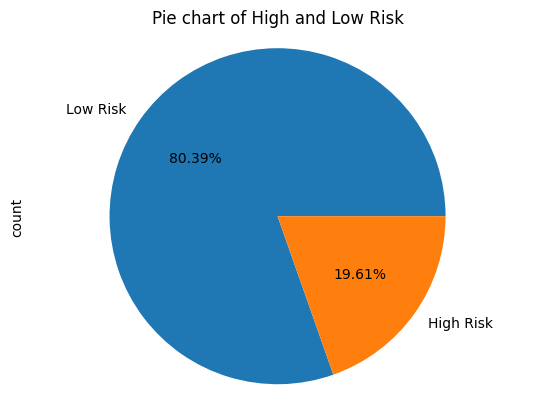

In [283]:
# Pie chart of High and Low Risk before Sampling
y_train.value_counts().plot.pie(autopct='%1.2f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk')
plt.show()

In [284]:
# Implemeting the RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='minority')
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train,y_train)

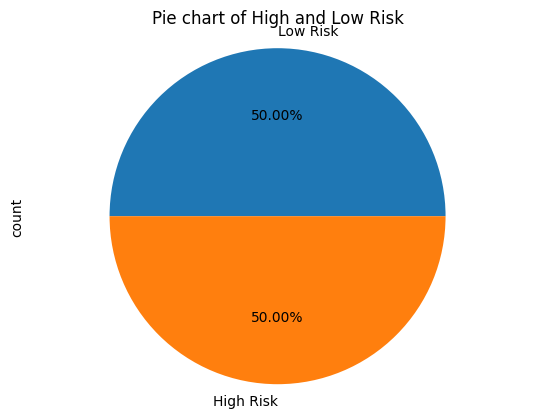

In [285]:
# Pie chart of High and Low Risk before Sampling
y_oversampled.value_counts().plot.pie(autopct='%1.2f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk')
plt.show()

In [286]:
import xgboost as xgb
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X,label=y)

# XGBoost Model
params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,
    'subsample': 0.85,
    'n_estimators': 900,
} 

xgb_clf = XGBClassifier(**params)

xgb_clf.fit(X_train_oversampled, y_train_oversampled)

y_pred_xgb = xgb_clf.predict(X_test)

# Calculate Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print('XGBoost model accuracy score: ', accuracy_xgb)

# Calculate F1 Score
f1_xgb = f1_score(y_test, y_pred_xgb)
print('F1 Score:', f1_xgb)

# Calculate AUC
y_pred_xgb = xgb_clf.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)
print('AUC:', auc_xgb)

XGBoost model accuracy score:  0.7983227935111356
F1 Score: 0.5451162790697675
AUC: 0.8250516524081294
